In [1]:
import geopandas as gdp
import pandas as pd
import matplotlib.pyplot as plt
from gerrychain import Graph, Partition, Election, MarkovChain, proposals, updaters, constraints, accept, GeographicPartition
from gerrychain.constraints import single_flip_contiguous 
from gerrychain.proposals import recom
from gerrychain.accept import cut_edge_accept
from gerrychain.updaters import Tally, cut_edges
from networkx import is_connected, connected_components
from functools import partial
import os

In [2]:
default_path = os.path.join(os.getcwd(), "..", "shapefiles", "processed")
FL_path = os.path.join(default_path, "florida", "precinct_level_w_election.shp")
UT_path = os.path.join(default_path, "utah", "UTAH_VTDs.shp")
NC_path = os.path.join(default_path, "north carolina", "precinct_level_w_election.shp")

In [3]:
NC_newGraph = gdp.read_file(NC_path)
NC_newGraph["R_VOTES"] = NC_newGraph["R_VOTES"].fillna(0)
NC_newGraph["D_VOTES"] = NC_newGraph["D_VOTES"].fillna(0)
NC_newGraph["R_VOTES"].isnull().max()
NC_newGraph["D_VOTES"].isnull().max()
NC_newGraph.to_file(NC_path)

In [4]:
FL_graph = Graph.from_file(FL_path, ignore_errors=True)
UT_graph = Graph.from_file(UT_path, ignore_errors=True)
NC_graph = Graph.from_file(NC_path, ignore_errors=True)

/home/mark/.local/lib/python3.9/site-packages/gerrychain/graph/adjacency.py:21: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  geometries[i].id = i
/home/mark/.local/lib/python3.9/site-packages/gerrychain/graph/adjacency.py:23: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree = STRtree(geometries)
/home/mark/.local/lib/python3.9/site-packages/gerrychain/graph/adjacency.py:66: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(539, 543), (1482, 3632), (3175, 3179), (4655, 4685), (1054, 1793), (4689, 4696), (770, 1607), (1321, 2384), (4006, 4010), (4225, 4314), (3998, 4006), (1520, 1547), (2830, 3935), (1718, 2596), (159, 178), (3478, 3482), (3529, 3564), (4006, 4028), (1505, 1567), (4599, 4622), (3068, 3089), (3270, 3322), (3910, 3911), (3100, 3121), (3709, 3741), (4377, 4713), (3068, 3107), (1831, 1835), (28

/home/mark/.local/lib/python3.9/site-packages/gerrychain/graph/graph.py:169: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()
/home/mark/.local/lib/python3.9/site-packages/gerrychain/graph/graph.py:296: UserWarning: NA values found in column TOT_POP!
  warnings.warn("NA values found in column {}!".format(column))
/home/mark/.local/lib/python3.9/site-packages/gerrychain/graph/graph.py:296: UserWarning: NA values found in column WHITE_POP!
  warnings.warn("NA values found in column {}!".format(column))
/home/mark/.local/lib/python3.9/site-packages/gerrychain/graph/graph.py:296: UserWarning: NA values found in column ASN_POP!
  warnings.warn("NA values found in column {}!".format(column))
/home/mark/.local/lib/python3.9/site-packages/gerrychain/graph/graph.py:296: UserWarning: NA values found in column BLK_POP!
  warnings.

/home/mark/.local/lib/python3.9/site-packages/gerrychain/graph/graph.py:296: UserWarning: NA values found in column SbPrcnc!
  warnings.warn("NA values found in column {}!".format(column))
/home/mark/.local/lib/python3.9/site-packages/gerrychain/graph/graph.py:296: UserWarning: NA values found in column AliasNm!
  warnings.warn("NA values found in column {}!".format(column))
/home/mark/.local/lib/python3.9/site-packages/gerrychain/graph/adjacency.py:21: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  geometries[i].id = i
/home/mark/.local/lib/python3.9/site-packages/gerrychain/graph/adjacency.py:23: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree = STRtree(geometries)


In [5]:
FL_graph.islands
FL_components = list(connected_components(FL_graph))
[len(c) for c in FL_components]

[4790, 2, 1, 3, 3, 1, 3, 1, 2]

In [6]:
FL_election = Election("SEN", {"Democratic": "D_VOTES", "Republican": "R_VOTES"})
UT_election = Election("SEN", {"Democratic": "D_VOTES", "Republican": "R_VOTES"})
NC_election = Election("SEN", {"Democratic": "D_VOTES", "Republican": "R_VOTES"})

/home/mark/.local/lib/python3.9/site-packages/gerrychain/updaters/tally.py:100: UserWarning: ignoring nan encountered at node '57' for attribute 'population' with fields ['TOT_POP']
  warnings.warn(
/home/mark/.local/lib/python3.9/site-packages/gerrychain/updaters/tally.py:100: UserWarning: ignoring nan encountered at node '658' for attribute 'population' with fields ['TOT_POP']
  warnings.warn(
/home/mark/.local/lib/python3.9/site-packages/gerrychain/updaters/tally.py:100: UserWarning: ignoring nan encountered at node '665' for attribute 'population' with fields ['TOT_POP']
  warnings.warn(
/home/mark/.local/lib/python3.9/site-packages/gerrychain/updaters/tally.py:100: UserWarning: ignoring nan encountered at node '2797' for attribute 'population' with fields ['TOT_POP']
  warnings.warn(
/home/mark/.local/lib/python3.9/site-packages/gerrychain/updaters/tally.py:100: UserWarning: ignoring nan encountered at node '2799' for attribute 'population' with fields ['TOT_POP']
  warnings.warn(

{'03': 1013123.0,
 '22': 893191.0,
 '20': 853144.0,
 '23': 687740.0,
 '24': 900444.0,
 '05': 1058763.0,
 'n/a': 511076.0,
 '06': 660129.0,
 '14': 774782.0,
 '15': 713648.0,
 '01': 821693.0,
 '19': 552165.0,
 '04': 638783.0,
 '10': 507642.0,
 '07': 645739.0,
 '09': 924057.0,
 '08': 662356.0,
 '13': 1236646.0,
 '18': 911380.0,
 '27': 1067515.0,
 '26': 912281.0,
 '21': 1400108.0}

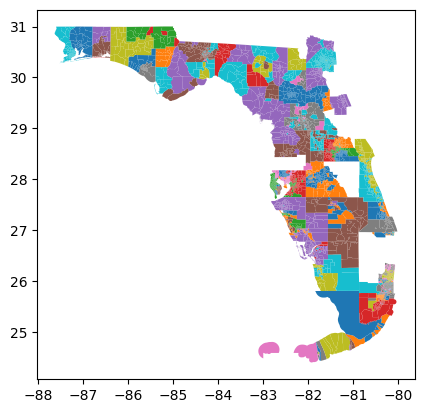

In [7]:
FL_init_partition = Partition(FL_graph, assignment="CONG_DIST", updaters={"population": Tally("TOT_POP", alias="population"),
        "cut_edges": cut_edges,
        "SEN": FL_election})
FL_init_partition.plot()
FL_init_partition["population"]

{1.0: 689746.3708065399,
 2.0: 692362.7309064252,
 3.0: 689861.0370456532,
 4.0: 692085.9179166325}

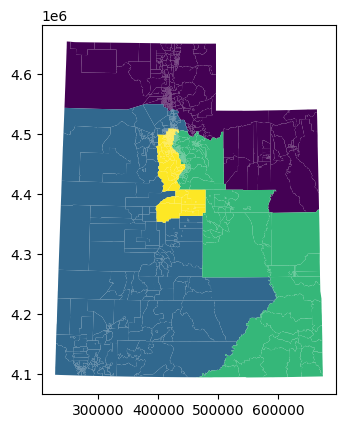

In [8]:
UT_init_partition = GeographicPartition(UT_graph, assignment="CD", updaters={"population": Tally("TOTPOP", alias="population"),
        "cut_edges": cut_edges,
        "SEN": UT_election})
UT_init_partition.plot()
UT_init_partition["population"]

13

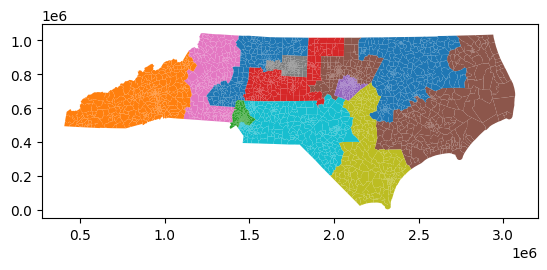

In [9]:
NC_init_partition = GeographicPartition(
        NC_graph, assignment="CD",
        updaters={
            "population": Tally("TOTPOP", alias="population"),
            "white": Tally("NH_WHITE", alias="white"),
            "black": Tally("NH_BLACK", alias="black"),
            "asian": Tally("NH_ASIAN", alias="asian"),
            "hisp": Tally("HISP", alias="hisp"),
            "other": Tally("NH_OTHER", alias="other"),
            "cut_edges": cut_edges,
            "SEN": NC_election})
NC_init_partition.plot()
NC_init_partition["population"]
len(NC_init_partition["SEN"].votes("Democratic"))

In [10]:
FL_ideal_pop = sum(FL_init_partition["population"].values()) / len(FL_init_partition)
FL_proposal = partial(recom, pop_col="TOT_POP", pop_target=FL_ideal_pop, epsilon=.02, node_repeats=2)
FL_compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(FL_init_partition["cut_edges"])
)
FL_pop_constraint = constraints.within_percent_of_ideal_population(FL_init_partition, 0.02)

In [11]:
UT_ideal_pop = sum(UT_init_partition["population"].values()) / len(UT_init_partition)
UT_proposal = partial(recom, pop_col="TOTPOP", pop_target=UT_ideal_pop, epsilon=.02, node_repeats=2)
UT_compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(UT_init_partition["cut_edges"])
)
UT_pop_constraint = constraints.within_percent_of_ideal_population(UT_init_partition, 0.02)

In [12]:
NC_ideal_pop = sum(NC_init_partition["population"].values()) / len(NC_init_partition)
NC_proposal = partial(recom, pop_col="TOTPOP", pop_target=NC_ideal_pop, epsilon=.02, node_repeats=2)
NC_compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(NC_init_partition["cut_edges"])
)
NC_pop_constraint = constraints.within_percent_of_ideal_population(NC_init_partition, 0.02)

In [13]:
iterations = 100
# FL_chain = MarkovChain(
#     proposal=FL_proposal,
#     constraints=[
#         FL_pop_constraint,
#         FL_compactness_bound
#     ],
#     accept=accept.always_accept,
#     initial_state=FL_init_partition,
#     total_steps=iterations
# )

In [14]:
UT_chain = MarkovChain(
    proposal=UT_proposal,
    constraints=[
        UT_pop_constraint,
        UT_compactness_bound
    ],
    accept=accept.always_accept,
    initial_state=UT_init_partition,
    total_steps=iterations
)

<AxesSubplot: >

<AxesSubplot: >

<AxesSubplot: >

<AxesSubplot: >

<AxesSubplot: >

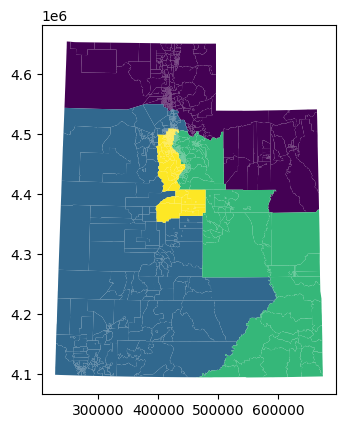

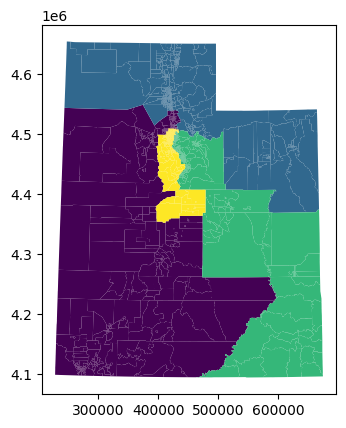

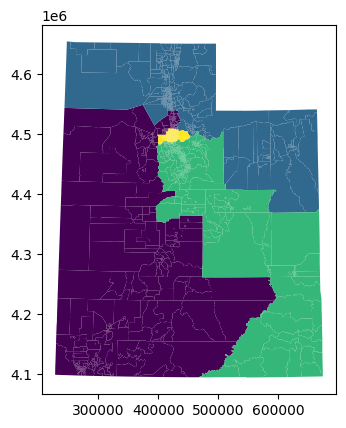

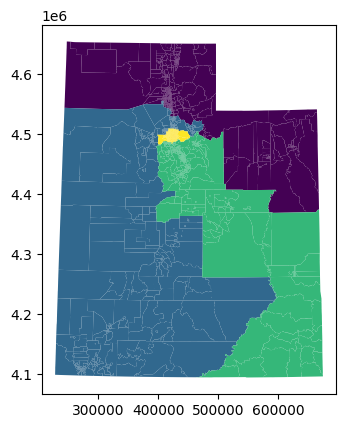

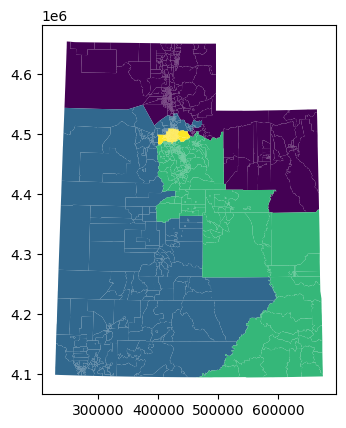

In [15]:
i = 0
for p in UT_chain:
    if i == 5:
        break
    display(p.plot())
    i += 1

In [16]:
NC_chain = MarkovChain(
    proposal=NC_proposal,
    constraints=[
        NC_pop_constraint,
        NC_compactness_bound
    ],
    accept=accept.always_accept,
    initial_state=NC_init_partition,
    total_steps=iterations
)

<AxesSubplot: >

<AxesSubplot: >

<AxesSubplot: >

<AxesSubplot: >

<AxesSubplot: >

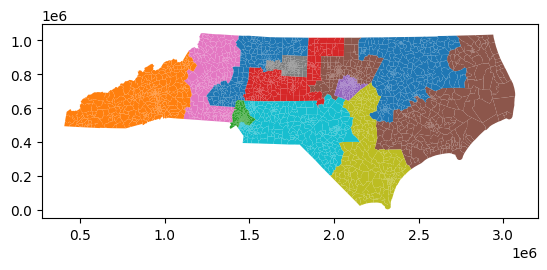

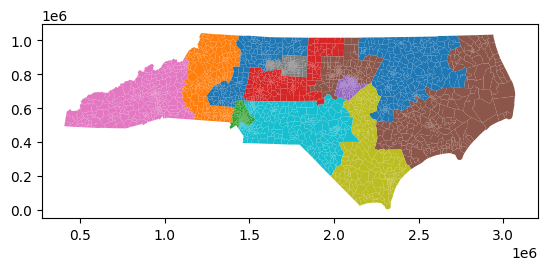

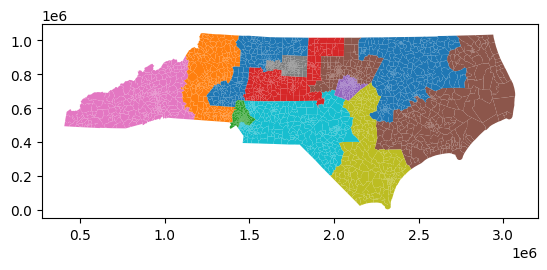

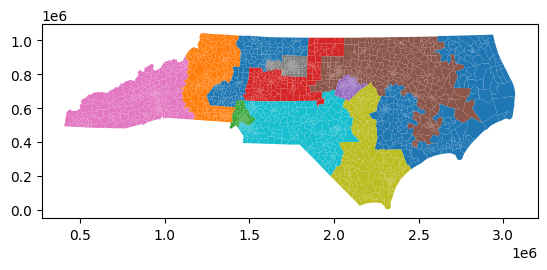

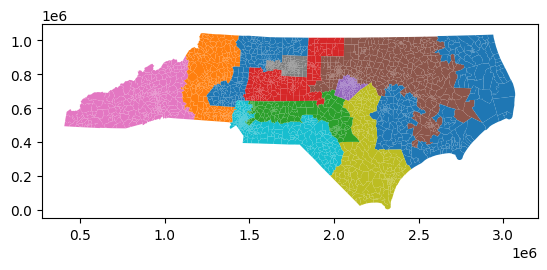

In [17]:
i = 0
for p in NC_chain:
    if i == 5:
        break
    display(p.plot())
    i += 1

In [29]:
votes_df = pd.DataFrame(sorted(partition["black"]) for partition in NC_chain)

ValueError: boxplot method requires numerical columns, nothing to plot.

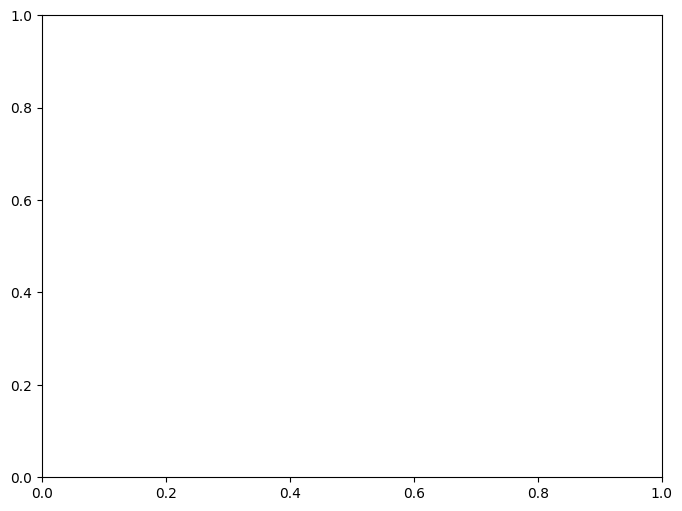

In [41]:
fig, ax = plt.subplots(figsize=(8, 6))
votes_df.boxplot(ax=ax, positions=13)
ax.axhline(0.5, color="#cccccc")
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.set_title("Comparing the blacks in North carolinas")
plt.show()

In [20]:
i = 0
for p in NC_chain:
    print(p["SEN"].__str__())
    print("-----------------------------")
    #     display(p["SEN"].total_votes())

Election Results for SEN
13:
  Democratic: 0.3182
  Republican: 0.6818
5:
  Democratic: 0.3178
  Republican: 0.6822
9:
  Democratic: 0.444
  Republican: 0.556
11:
  Democratic: 0.4371
  Republican: 0.5629
3:
  Democratic: 0.3664
  Republican: 0.6336
1:
  Democratic: 0.5412
  Republican: 0.4588
7:
  Democratic: 0.3966
  Republican: 0.6034
8:
  Democratic: 0.4666
  Republican: 0.5334
10:
  Democratic: 0.3099
  Republican: 0.6901
4:
  Democratic: 0.6734
  Republican: 0.3266
6:
  Democratic: 0.6226
  Republican: 0.3774
12:
  Democratic: 0.9976
  Republican: 0.0024
2:
  Democratic: 0.6438
  Republican: 0.3562
-----------------------------
Election Results for SEN
13:
  Democratic: 0.3509
  Republican: 0.6491
5:
  Democratic: 0.3178
  Republican: 0.6822
9:
  Democratic: 0.444
  Republican: 0.556
11:
  Democratic: 0.4371
  Republican: 0.5629
3:
  Democratic: 0.3664
  Republican: 0.6336
1:
  Democratic: 0.5412
  Republican: 0.4588
7:
  Democratic: 0.3966
  Republican: 0.6034
8:
  Democratic: 0

Election Results for SEN
13:
  Democratic: 0.3199
  Republican: 0.6801
5:
  Democratic: 0.439
  Republican: 0.561
9:
  Democratic: 0.3602
  Republican: 0.6398
11:
  Democratic: 0.8982
  Republican: 0.1018
3:
  Democratic: 0.5179
  Republican: 0.4821
1:
  Democratic: 0.3822
  Republican: 0.6178
7:
  Democratic: 0.3966
  Republican: 0.6034
8:
  Democratic: 0.465
  Republican: 0.535
10:
  Democratic: 0.5354
  Republican: 0.4646
4:
  Democratic: 0.5252
  Republican: 0.4748
6:
  Democratic: 0.3819
  Republican: 0.6181
12:
  Democratic: 0.6549
  Republican: 0.3451
2:
  Democratic: 0.6438
  Republican: 0.3562
-----------------------------
Election Results for SEN
13:
  Democratic: 0.3199
  Republican: 0.6801
5:
  Democratic: 0.439
  Republican: 0.561
9:
  Democratic: 0.3372
  Republican: 0.6628
11:
  Democratic: 0.9191
  Republican: 0.0809
3:
  Democratic: 0.5179
  Republican: 0.4821
1:
  Democratic: 0.3822
  Republican: 0.6178
7:
  Democratic: 0.3966
  Republican: 0.6034
8:
  Democratic: 0.4

Election Results for SEN
13:
  Democratic: 0.3356
  Republican: 0.6644
5:
  Democratic: 0.3452
  Republican: 0.6548
9:
  Democratic: 0.4419
  Republican: 0.5581
11:
  Democratic: 0.4753
  Republican: 0.5247
3:
  Democratic: 0.5231
  Republican: 0.4769
1:
  Democratic: 0.3817
  Republican: 0.6183
7:
  Democratic: 0.4041
  Republican: 0.5959
8:
  Democratic: 0.8796
  Republican: 0.1204
10:
  Democratic: 0.5352
  Republican: 0.4648
4:
  Democratic: 0.6524
  Republican: 0.3476
6:
  Democratic: 0.3686
  Republican: 0.6314
12:
  Democratic: 0.554
  Republican: 0.446
2:
  Democratic: 0.6174
  Republican: 0.3826
-----------------------------
Election Results for SEN
13:
  Democratic: 0.3356
  Republican: 0.6644
5:
  Democratic: 0.3452
  Republican: 0.6548
9:
  Democratic: 0.4419
  Republican: 0.5581
11:
  Democratic: 0.4753
  Republican: 0.5247
3:
  Democratic: 0.5231
  Republican: 0.4769
1:
  Democratic: 0.3817
  Republican: 0.6183
7:
  Democratic: 0.4041
  Republican: 0.5959
8:
  Democratic:

Election Results for SEN
13:
  Democratic: 0.4602
  Republican: 0.5398
5:
  Democratic: 0.887
  Republican: 0.113
9:
  Democratic: 0.4403
  Republican: 0.5597
11:
  Democratic: 0.3435
  Republican: 0.6565
3:
  Democratic: 0.5364
  Republican: 0.4636
1:
  Democratic: 0.3725
  Republican: 0.6275
7:
  Democratic: 0.6489
  Republican: 0.3511
8:
  Democratic: 0.3597
  Republican: 0.6403
10:
  Democratic: 0.396
  Republican: 0.604
4:
  Democratic: 0.5157
  Republican: 0.4843
6:
  Democratic: 0.525
  Republican: 0.475
12:
  Democratic: 0.4379
  Republican: 0.5621
2:
  Democratic: 0.6174
  Republican: 0.3826
-----------------------------
Election Results for SEN
13:
  Democratic: 0.4602
  Republican: 0.5398
5:
  Democratic: 0.887
  Republican: 0.113
9:
  Democratic: 0.4403
  Republican: 0.5597
11:
  Democratic: 0.3435
  Republican: 0.6565
3:
  Democratic: 0.5364
  Republican: 0.4636
1:
  Democratic: 0.3725
  Republican: 0.6275
7:
  Democratic: 0.6489
  Republican: 0.3511
8:
  Democratic: 0.361

Election Results for SEN
13:
  Democratic: 0.4348
  Republican: 0.5652
5:
  Democratic: 0.8442
  Republican: 0.1558
9:
  Democratic: 0.4403
  Republican: 0.5597
11:
  Democratic: 0.2914
  Republican: 0.7086
3:
  Democratic: 0.4377
  Republican: 0.5623
1:
  Democratic: 0.4607
  Republican: 0.5393
7:
  Democratic: 0.6489
  Republican: 0.3511
8:
  Democratic: 0.3951
  Republican: 0.6049
10:
  Democratic: 0.4319
  Republican: 0.5681
4:
  Democratic: 0.6373
  Republican: 0.3627
6:
  Democratic: 0.525
  Republican: 0.475
12:
  Democratic: 0.4636
  Republican: 0.5364
2:
  Democratic: 0.4962
  Republican: 0.5038
-----------------------------
Election Results for SEN
13:
  Democratic: 0.4348
  Republican: 0.5652
5:
  Democratic: 0.8442
  Republican: 0.1558
9:
  Democratic: 0.4403
  Republican: 0.5597
11:
  Democratic: 0.2914
  Republican: 0.7086
3:
  Democratic: 0.4377
  Republican: 0.5623
1:
  Democratic: 0.4607
  Republican: 0.5393
7:
  Democratic: 0.6489
  Republican: 0.3511
8:
  Democratic:

Election Results for SEN
13:
  Democratic: 0.408
  Republican: 0.592
5:
  Democratic: 0.8442
  Republican: 0.1558
9:
  Democratic: 0.4385
  Republican: 0.5615
11:
  Democratic: 0.311
  Republican: 0.689
3:
  Democratic: 0.5157
  Republican: 0.4843
1:
  Democratic: 0.6327
  Republican: 0.3673
7:
  Democratic: 0.6489
  Republican: 0.3511
8:
  Democratic: 0.5315
  Republican: 0.4685
10:
  Democratic: 0.4841
  Republican: 0.5159
4:
  Democratic: 0.4944
  Republican: 0.5056
6:
  Democratic: 0.3846
  Republican: 0.6154
12:
  Democratic: 0.4137
  Republican: 0.5863
2:
  Democratic: 0.387
  Republican: 0.613
-----------------------------
Election Results for SEN
13:
  Democratic: 0.408
  Republican: 0.592
5:
  Democratic: 0.8442
  Republican: 0.1558
9:
  Democratic: 0.4385
  Republican: 0.5615
11:
  Democratic: 0.311
  Republican: 0.689
3:
  Democratic: 0.5157
  Republican: 0.4843
1:
  Democratic: 0.5298
  Republican: 0.4702
7:
  Democratic: 0.6489
  Republican: 0.3511
8:
  Democratic: 0.5315


Election Results for SEN
13:
  Democratic: 0.408
  Republican: 0.592
5:
  Democratic: 0.4477
  Republican: 0.5523
9:
  Democratic: 0.31
  Republican: 0.69
11:
  Democratic: 0.4361
  Republican: 0.5639
3:
  Democratic: 0.4293
  Republican: 0.5707
1:
  Democratic: 0.6045
  Republican: 0.3955
7:
  Democratic: 0.6305
  Republican: 0.3695
8:
  Democratic: 0.8476
  Republican: 0.1524
10:
  Democratic: 0.5383
  Republican: 0.4617
4:
  Democratic: 0.484
  Republican: 0.516
6:
  Democratic: 0.3846
  Republican: 0.6154
12:
  Democratic: 0.4328
  Republican: 0.5672
2:
  Democratic: 0.5543
  Republican: 0.4457
-----------------------------
Election Results for SEN
13:
  Democratic: 0.4173
  Republican: 0.5827
5:
  Democratic: 0.4477
  Republican: 0.5523
9:
  Democratic: 0.31
  Republican: 0.69
11:
  Democratic: 0.4361
  Republican: 0.5639
3:
  Democratic: 0.4181
  Republican: 0.5819
1:
  Democratic: 0.6045
  Republican: 0.3955
7:
  Democratic: 0.6305
  Republican: 0.3695
8:
  Democratic: 0.8476
  

In [47]:
i = 0
for p in NC_chain:
    display(p["SEN"].efficiency_gap())

-0.11259274722596649

-0.11848360706064381

-0.1183643994230426

-0.11652546575519739

-0.11652546575519739

-0.11859469119837682

-0.11415623757269824

-0.11107176356459174

-0.11107176356459174

-0.11107176356459174

-0.10616006884193842

-0.10669470848442886

-0.18163078315261694

-0.11024222198502442

-0.11024222198502442

-0.11024222198502442

-0.11024222198502442

-0.11019574800903409

-0.11019574800903409

-0.11180212287832603

-0.11180212287832603

-0.11180212287832603

-0.11180212287832603

-0.1116502323226503

-0.1111150259243551

-0.1111150259243551

-0.1111150259243551

-0.11187995734217976

-0.11331706114444999

-0.11331706114444999

-0.11424540715264718

-0.11424540715264718

-0.10929630654687968

-0.10929630654687968

-0.10580679105697124

-0.10572933443032068

-0.10572933443032068

-0.10572933443032068

-0.10586894527689328

-0.10586894527689328

-0.10586894527689328

-0.10586894527689328

-0.10586894527689328

-0.10586894527689328

-0.10586894527689328

-0.10586894527689328

-0.10586894527689328

-0.10436061916182485

-0.10436061916182485

-0.1030404559739368

-0.1030404559739368

-0.1030404559739368

-0.10289536648791818

-0.1034075248168198

-0.1034075248168198

-0.1034075248168198

-0.1034075248168198

-0.10277030237366777

-0.1049861286516785

-0.1049861286516785

-0.1049861286516785

-0.1069289675503964

-0.1069289675503964

-0.1069289675503964

-0.03331456741890905

-0.03331456741890905

-0.03331456741890905

-0.03449058571378643

-0.03449058571378643

-0.03449058571378643

-0.03449058571378643

-0.03449058571378643

-0.03449058571378643

-0.03449058571378643

-0.03449058571378643

-0.10473770069059195

-0.10473770069059195

-0.10453555778689415

-0.1035569594306749

-0.10323220835454731

-0.10397144684255619

-0.10397144684255619

-0.10146978672034473

-0.17535301802189

-0.10627644270051584

-0.10522681095009999

-0.10438952370786761

-0.10438952370786761

-0.10438952370786761

-0.10612681916805916

-0.035879704191253636

-0.03388566835150573

-0.03388566835150573

-0.03388566835150573

-0.03388566835150573

-0.03388566835150573

-0.03417112435850327

-0.03259837700029377

-0.03259837700029377

-0.03259837700029377